<a href="https://colab.research.google.com/github/stefanogiagu/corso_AI_2023/blob/main/notebooks/examples/PyTorch_SimpleMLP_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Implementation of a basic pytorch MLP architecture to illustrate a tipical DL pipeline implemented in pytorch
#
# Stefano Giagu - v1.2 - 26.4.2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.0.0+cu118
0.15.1+cu118


In [3]:
# in torch/pytorch data and models must be moved in the specific processing unit
# this code snippet allows to set the variable "device" according to available resurce (cpu or cuda gpu)

if torch.cuda.is_available():
  print('number of devices: ', torch.cuda.device_count())
  print(torch.cuda.get_device_name(0))

device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

number of devices:  1
Tesla T4
Computation device: cuda



In [4]:
# Dataset: in this simple toy example, we'll produce a toy dataset generated using numpy 
# 
# task: a two class classification problem, with 8 uncorrelated features, gaussian distributed with different 
# means and variance among features and classes

features_S = np.random.normal(loc=[-4.,-3.,-2.,-1.,1.,2.,3.,4.], scale=np.random.uniform(0.2,0.7,size=(8)), size=(2000,8))
features_B = np.random.normal(loc=[-4.5,-3.5,-2.5,-1.5,1.5,2.5,3.5,4.5], scale=np.random.uniform(0.2,0.7,size=(8)), size=(2000,8))

labels_S = np.zeros(shape=(2000)) #label 0 for class S
labels_B = np.ones(shape=(2000))  #label 1 for class B

# concatenate S and B in one dataset
X = np.concatenate((features_S, features_B), axis=0)
Y = np.concatenate((labels_S, labels_B), axis=0)

# divide the dataset in train and test
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=12345)
X_train, X_vali, Y_train, Y_vali = train_test_split(X_train, Y_train, test_size=0.2, shuffle=True, random_state=456789)
print(X_train.shape)
print(Y_train.shape)
print(X_vali.shape)
print(Y_vali.shape)
print(X_test.shape)
print(Y_test.shape)

(2560, 8)
(2560,)
(640, 8)
(640,)
(800, 8)
(800,)


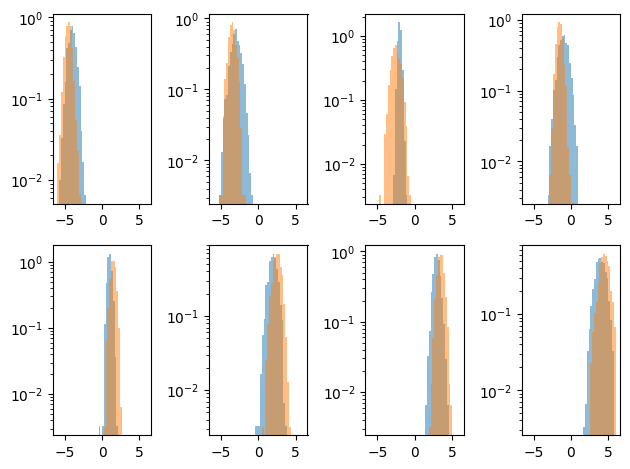

In [5]:
# plot variables

sel_S = tuple([Y_train<0.5])
sel_B = tuple([Y_train>0.5])

for idx in range(8):
  plt.subplot(2,4,idx+1)
  plt.hist((X_train[sel_S])[:,idx], bins=50, range=[-6.,6.], alpha=0.5, log=True, density=True)
  plt.hist((X_train[sel_B])[:,idx], bins=50, range=[-6.,6.], alpha=0.5, log=True, density=True)
plt.tight_layout()

In [6]:
# transform the numpy arrays to torch tensors (pytorch works with torch tensors)

# in deep learning, tensors are a fundamental data structure that is very similar to arrays and matrices, 
# with which we can efficiently perform mathematical operations on large sets of data. A tensor can be represented 
# as a matrix, but also as a vector, a scalar, or a higher-dimensional array.

# a torch tensor is a structure very similar to a numpy ndarray, with the difference that they are capable of running on a 
# GPU, which dramatically speeds up the computational process

X_train_pt = torch.Tensor(X_train).float()
Y_train_pt = torch.Tensor(Y_train).int()
X_vali_pt = torch.Tensor(X_vali).float()
Y_vali_pt = torch.Tensor(Y_vali).int()
X_test_pt = torch.Tensor(X_test).float()
Y_test_pt = torch.Tensor(Y_test).int()

print(X_train_pt.shape)
print(Y_train_pt.shape)
print(X_vali_pt.shape)
print(Y_vali_pt.shape)
print(X_test_pt.shape)
print(Y_test_pt.shape)

torch.Size([2560, 8])
torch.Size([2560])
torch.Size([640, 8])
torch.Size([640])
torch.Size([800, 8])
torch.Size([800])


In [7]:
# create a pytorch dataset (a python abstraction that allows to load and process each sample of the dataset)
# and a pytorch dataloader (a python iterable that allows to iterate among sample's events, taking care of 
# shuffling/sampling/weigthed sampling, batching, using multiprocessing to load the data. etc...

from torch.utils.data import TensorDataset, DataLoader

dataset_train = TensorDataset(X_train_pt, Y_train_pt) # a datset are pair of feature tensor, target tensor

dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True) #the dataset will be shuffled and batched in mini batch of 32 event each

dataset_vali = TensorDataset(X_vali_pt, Y_vali_pt) 
dataloader_vali = DataLoader(dataset_vali, batch_size=32, shuffle=True) 

In [9]:
# example of iteration through the dataloader

train_features, train_labels = next(iter(dataloader_train))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

an_event = train_features[0].squeeze()
a_label = train_labels[0]

print(f"Feature: {an_event}")
print(f"Label: {a_label}")

Feature batch shape: torch.Size([32, 8])
Labels batch shape: torch.Size([32])
Feature: tensor([-4.3248, -3.7378, -2.9276, -1.6957,  1.4673,  2.6675,  3.9194,  4.5849])
Label: 1


In [8]:
# note: move torch tensors between cpu and gpu

print('X_train_pt is in GPU: ', X_train_pt.is_cuda)
X_train_pt = X_train_pt.to(device)
print('X_train_pt is in GPU: ', X_train_pt.is_cuda)
X_train_pt = X_train_pt.to('cpu')
print('X_train_pt is in GPU: ', X_train_pt.is_cuda)


# alteranative way (earlier torch style)
# use .cuda() e .cpu()
print('X_train_pt is in GPU: ', X_train_pt.cpu())
print('X_train_pt is in GPU: ', X_train_pt.cuda())

X_train_pt is in GPU:  False
X_train_pt is in GPU:  True
X_train_pt is in GPU:  False
X_train_pt is in GPU:  tensor([[-4.4294, -3.1727, -1.8277,  ...,  2.8967,  3.1556,  5.2151],
        [-4.2175, -2.9328, -1.9601,  ...,  2.8143,  3.6384,  4.3580],
        [-4.6253, -3.4915, -1.9062,  ...,  1.6677,  3.2720,  4.7680],
        ...,
        [-3.9606, -3.8101, -1.7732,  ...,  2.6597,  3.2526,  4.2049],
        [-3.9449, -3.7184, -1.6111,  ...,  1.8121,  4.1046,  4.8630],
        [-4.3935, -3.9709, -3.0241,  ...,  2.6542,  3.6785,  3.7905]])
X_train_pt is in GPU:  tensor([[-4.4294, -3.1727, -1.8277,  ...,  2.8967,  3.1556,  5.2151],
        [-4.2175, -2.9328, -1.9601,  ...,  2.8143,  3.6384,  4.3580],
        [-4.6253, -3.4915, -1.9062,  ...,  1.6677,  3.2720,  4.7680],
        ...,
        [-3.9606, -3.8101, -1.7732,  ...,  2.6597,  3.2526,  4.2049],
        [-3.9449, -3.7184, -1.6111,  ...,  1.8121,  4.1046,  4.8630],
        [-4.3935, -3.9709, -3.0241,  ...,  2.6542,  3.6785,  3.7905]],


In [10]:
# a pytorch nn model: it is just a python class inheriting from nn.Module that defines 
# the layers and activations used in the DNN model and a forward(x) method that defines 
# how the model act on an input example x

from torch import nn
import torch.nn.functional as F

# as a basic example let'd define a shallow ANN with a dense layer with 20 neurons
class ShallowANN(nn.Module):
  def __init__(self, input_dim):
    super(ShallowANN, self).__init__()
    
    #torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
    #Linear in pytorch is the equivalent of Dense in keras
    self.layer1 = nn.Linear(input_dim, 20)
    self.activ1 = nn.ReLU()
    self.layer2 = nn.Linear(20, 1)
    self.activ2 = nn.Sigmoid()
    
  def forward(self, x):
    out = self.layer1(x) 
    out = self.activ1(out) 
    out = self.layer2(out) #alternatively the two statements can be replaced 
    out = self.activ2(out) #out = torch.sigmoid(self.layer2(out))
    return out

# note: it is strightfoward to modify the class to implement a MLP

# example MLP: with 3 hidden layers

class MyMLP(nn.Module):
  def __init__(self):
    super(MyMLP, self).__init__()
    
    self.layer1 = nn.Linear(8, 20)
    self.activ1 = nn.ReLU()
    self.layer2 = nn.Linear(20, 50)
    self.activ2 = nn.ReLU()
    self.layer3 = nn.Linear(50, 100)
    self.activ3 = nn.ReLU()
    self.layer4 = nn.Linear(100, 1)
    self.activ4 = nn.Sigmoid()
    
  def forward(self, x):
    out = self.layer1(x)
    out = self.activ1(out)
    out = self.layer2(out)
    out = self.activ2(out)
    out = self.layer3(out)
    out = self.activ3(out)
    out = self.layer4(out)
    out = self.activ4(out)
    return out


# alternative implementation 
class MyMLP2(nn.Module):
  def __init__(self):
    super(MyMLP2, self).__init__()

    self.mlp_block = nn.Sequential( #similar to keras keras.Sequential module
      nn.Linear(8, 20),
      nn.ReLU(),
      nn.Linear(20, 50),
      nn.ReLU(),
      nn.Linear(50, 100),
      nn.ReLU()
    )
    
    self.out_block = nn.Linear(100, 1)
    
  def forward(self, x):
    out = torch.sigmoid(self.out_block(self.mlp(x)))
    return out

In [11]:
%pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
# print the model architecture

# simple printing
model = ShallowANN(input_dim=8)
print(model)

# torchsummary (keras-like) printing
from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(1,8))
else:
  summary(model, input_size=(1,8))

ShallowANN(
  (layer1): Linear(in_features=8, out_features=20, bias=True)
  (activ1): ReLU()
  (layer2): Linear(in_features=20, out_features=1, bias=True)
  (activ2): Sigmoid()
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 20]             180
              ReLU-2                [-1, 1, 20]               0
            Linear-3                 [-1, 1, 1]              21
           Sigmoid-4                 [-1, 1, 1]               0
Total params: 201
Trainable params: 201
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [15]:
# instantiate a new model (reset weight etc) and put it on GPU
model = ShallowANN(input_dim=8)
model.to(device)
print('model is on GPU: ',next(model.parameters()).is_cuda)

model is on GPU:  True


In [14]:
#install torchmetrics: collection of useful PyTorch metrics implementations and an easy-to-use API to create custom metrics
%pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 14.4 MB/s eta 0:00:00


In [16]:
#loss function

# in classificiation task the most used loos ic cross-entropy. In pytorch we have:
# BCELoss for binary classification 
# CrossEntropyLoss for multiclass classification (NOTE: CrossEntropyLoss already includes softmax calculation internally, so output of 
# the ANN foward method must be logits (eg no softmax/sigmoid))

loss_func = nn.BCELoss() #binary cross entropy loss

# metrics
# binary accuracy:  torchmetrics.functional.classification.binary_accuracy(preds, target)
import torchmetrics
from torchmetrics.functional.classification import binary_accuracy

metric_func = binary_accuracy

# altrenatively you can wroiwritete your own binary accuracy metric
def my_binary_accuracy(yhat, y):
  assert y.ndim == 1 and y.size() == yhat.size()
  yhat = yhat > 0.5
  return (y == yhat).sum().item() / y.size(0)

my_metric_func = my_binary_accuracy


# optimizer

from torch import optim

# plain SGD + momentum
#opt = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# or for example

opt = optim.Adam(model.parameters(), lr=1e-3)

# scheduler for multi step decay lr schedule
# Decays the learning rate of each parameter group by gamma once the number of epoch reaches one of the milestones
#lr_scheduler = optim.lr_scheduler.MultiStepLR(opt, milestones=[20,40,60], gamma=0.1)

In [17]:
# test implementation on one batch before to train
xb,yb = next(iter(dataloader_train))

xb=xb.type(torch.float).to(device) #put tensors on device
yb=yb.type(torch.float).to(device)

# prediction

pred = model(xb)
print('output shape: ', pred.shape)

# loss and metric
loss = loss_func(pred, torch.unsqueeze(yb,1))
metric = metric_func(pred, torch.unsqueeze(yb,1))
#or also: metric = metric_func(torch.squeeze(pred), yb)
mymetric = my_metric_func(torch.squeeze(pred), yb)

print('loss: ', loss.item())
print('metric: ', metric.item())
print('my_metric: ', mymetric)

output shape:  torch.Size([32, 1])
loss:  0.7264176607131958
metric:  0.375
my_metric:  0.375


In [18]:
# training loop (in pytorch you need to write yourself  (eg no .fit() method like in sklearn) 
# (alternatively use PyTorch Lightning for more keras-like APIs))

import time
epochs = 100

# define a couple of lists to store loss and accuracy during training for monitorin purposes
hist_loss = []
hist_metric = []
hist_val_loss = []
hist_val_metric = []

#-----
for epoch in range(epochs): # loop over epochs
    t0 = time.time()
    
    #training step
    model.train() #important!

    train_loss = 0.0
    train_metric = 0.0
    counter = 0
    
    for xb, yb in dataloader_train: #loop over minibatches
        counter += 1

        #move data and target to device
        xb=xb.type(torch.float).to(device)
        yb=yb.type(torch.float).to(device)

        #get model prediction
        pred = model(xb)

        # compute loss
        loss = loss_func(pred, torch.unsqueeze(yb,1))

        # compute metric

        metric = metric_func(pred, torch.unsqueeze(yb,1))
        train_loss += loss.item()
        train_metric += metric.item()

        # backpropagation
        loss.backward()
        opt.step()
        opt.zero_grad()
 
    train_loss = train_loss/counter
    train_metric = train_metric/counter

    hist_loss.append(train_loss)
    hist_metric.append(train_metric)

#-----
    # validation step
    model.eval() #important! will set layers that have different behavior in training vs validation (ex. dropout) for validation

    vali_loss = 0.0
    vali_metric = 0.0
    counter = 0
    
    with torch.no_grad(): #disable gradients calculation in autograd (it will reduce memory consumption for computations)
      for xb, yb in dataloader_vali:
        counter += 1
        xb=xb.type(torch.float).to(device)
        yb=yb.type(torch.float).to(device)
        pred = model(xb)
        vloss = loss_func(pred, torch.unsqueeze(yb,1))
        vmetric = metric_func(pred, torch.unsqueeze(yb,1))
        vali_loss += vloss.item()
        vali_metric += vmetric.item()
        
    vali_loss = vali_loss/counter
    vali_metric = vali_metric/counter    

    hist_val_loss.append(vali_loss)
    hist_val_metric.append(vali_metric)

    elapsed_time = time.time()-t0
    #current_lr = lr_scheduler.get_last_lr()[0]
    #print("epoch: %d, time(s): %.4f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f, lr : %1.2e" 
    #      % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric, current_lr))
    print("epoch: %d, time(s): %.4f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f" 
          % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric))
    
    # update learning rate schedule
    #lr_scheduler.step()

epoch: 1, time(s): 0.4519, train loss: 0.680480, train metric: 0.574609, vali loss: 0.651798, vali metric: 0.687500
epoch: 2, time(s): 0.1968, train loss: 0.634341, train metric: 0.687109, vali loss: 0.623687, vali metric: 0.615625
epoch: 3, time(s): 0.2028, train loss: 0.602669, train metric: 0.722656, vali loss: 0.587498, vali metric: 0.725000
epoch: 4, time(s): 0.2002, train loss: 0.573232, train metric: 0.736719, vali loss: 0.556717, vali metric: 0.759375
epoch: 5, time(s): 0.1937, train loss: 0.546561, train metric: 0.762500, vali loss: 0.527446, vali metric: 0.770312
epoch: 6, time(s): 0.1957, train loss: 0.525122, train metric: 0.764453, vali loss: 0.509656, vali metric: 0.767188
epoch: 7, time(s): 0.1951, train loss: 0.504619, train metric: 0.770703, vali loss: 0.482071, vali metric: 0.793750
epoch: 8, time(s): 0.1890, train loss: 0.490064, train metric: 0.786719, vali loss: 0.469158, vali metric: 0.779687
epoch: 9, time(s): 0.1999, train loss: 0.476382, train metric: 0.782031,

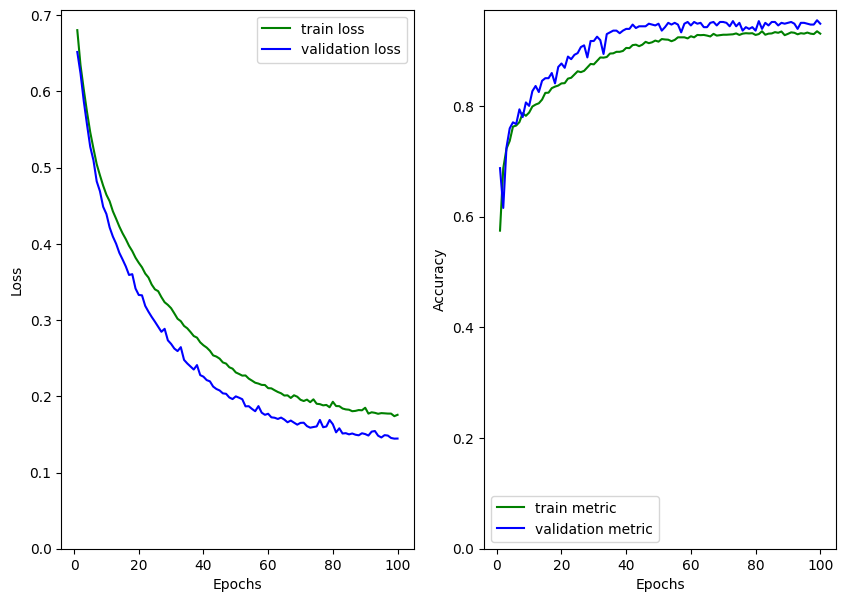

In [19]:
# plot training results (loss and accuracy vs epoch)
plt.figure(figsize=(10, 7))
plt.subplot(1,2,1)
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_val_loss)+1), hist_val_loss, color='blue', linestyle='-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(ymin = 0.0)
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1,len(hist_metric)+1), hist_metric,  color='green', linestyle='-', label='train metric')
plt.plot(range(1,len(hist_val_metric)+1),hist_val_metric, color='blue', linestyle='-', label='validation metric')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(ymin = 0.0)
plt.legend()

In [20]:
#test the trained model 

# let's test it on cpu
model.to(torch.device("cpu"))

X_test_pt = X_test_pt.type(torch.float).to(torch.device("cpu"))
res = model(X_test_pt)

In [21]:
print('Test accuracy: ',binary_accuracy(res, torch.unsqueeze(Y_test_pt,1)).item())

Test accuracy:  0.9262499809265137
